### Evaluator-optimizer
The evaluator-optimizer workflow represents a sophisticated approach to content generation that mimics human creative processes. This pattern iteratively improves outputs by generating initial content and systematically refining it based on structured feedback from an evaluation model. The workflow creates a feedback loop where each iteration builds upon the previous one, leading to progressively better results.

#### Core Concept
The evaluator-optimizer pattern operates on a simple yet powerful principle: generate, evaluate, and refine. This iterative approach ensures that the final output meets specific quality standards before being accepted. The pattern consists of two primary components:
- Generator: Creates initial content or refines existing content based on feedback
- Evaluator: Assesses the quality of generated content against predefined criteria

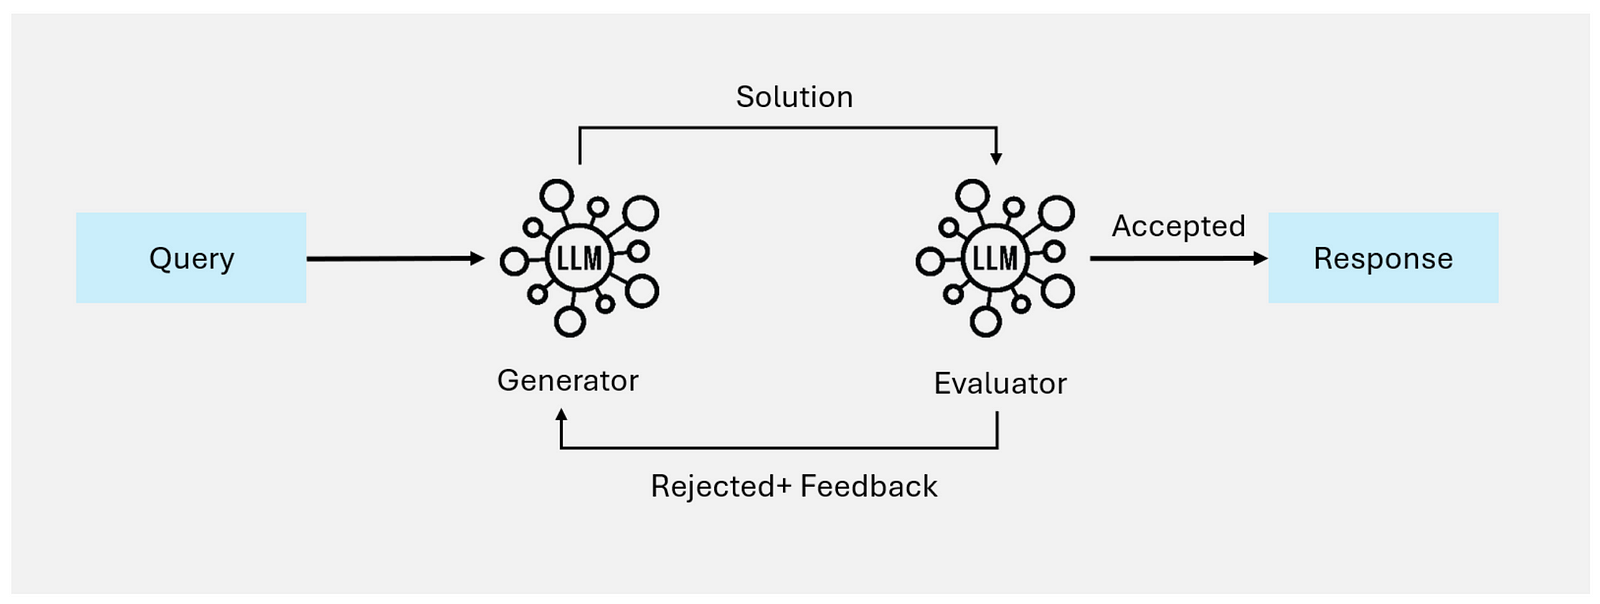

### Step 1: Environment Setup and Dependencies
Set up the necessary libraries and environment for our iterative content generation system.

In [ ]:
import os
from dotenv import load_dotenv
from typing import Annotated, List, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display

from langchain_aws import ChatBedrock


### Step 2: Model Initialization
Initialize the language model that will be used for both content generation and evaluation.

In [ ]:
# Load environment variables and initialize the language model
load_dotenv()

content_generator = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")


### Step 3: State Schema Definition
Define the structure that will hold all information as our workflow progresses through iterations.

In [ ]:
# Define the state schema for the workflow
class WorkflowState(TypedDict):
    """State management for the evaluator-optimizer workflow"""
    generated_content: str      # The current version of generated content
    content_topic: str          # The topic or subject for content generation
    evaluation_feedback: str    # Feedback from the evaluator
    quality_assessment: str     # Binary assessment: "approved" or "needs_improvement"


### Step 4: Evaluation Schema Definition and Structured Output Configuration
Create a structured format for the evaluator's output to ensure consistent, parseable feedback.

In [ ]:
# Schema for structured evaluation output
class ContentEvaluation(BaseModel):
    """Structured output schema for content evaluation"""
    
    quality_grade: Literal["approved", "needs_improvement"] = Field(
        description="Determine if the content meets quality standards or needs improvement"
    )
    improvement_feedback: str = Field(
        description="If content needs improvement, provide specific actionable feedback"
    )

# Configure the evaluator with structured output
content_evaluator = content_generator.with_structured_output(ContentEvaluation)


### Step 5: Content Generation Node
Create the core function that generates initial content or refines existing content based on feedback.

In [ ]:
# Node Functions
def generate_content(state: WorkflowState) -> dict:
    """
    Generate or refine content based on topic and optional feedback
    
    Args:
        state: Current workflow state containing topic and feedback
        
    Returns:
        Dictionary with updated generated content
    """
    
    if state.get("evaluation_feedback"):
        # Generate improved content based on feedback
        prompt = f"""
        Create a joke about {state['content_topic']} while incorporating this feedback: 
        {state['evaluation_feedback']}
        
        Make sure to address the specific points mentioned in the feedback.
        """
    else:
        # Generate initial content
        prompt = f"Create a well-crafted, humorous joke about {state['content_topic']}"
    
    response = content_generator.invoke(prompt)
    return {"generated_content": response.content}



### Step 6: Content Evaluation Node
Create the evaluator that assesses content quality and provides structured feedback.

In [ ]:
def evaluate_content(state: WorkflowState) -> dict:
    """
    Evaluate the generated content against quality criteria
    
    Args:
        state: Current workflow state containing generated content
        
    Returns:
        Dictionary with evaluation results and feedback
    """
    
    evaluation_prompt = f"""
    Evaluate the following joke for quality and humor:
    
    Joke: {state['generated_content']}
    
    Consider these criteria:
    1. Is it genuinely funny or clever?
    2. Is it appropriate and inoffensive?
    3. Does it make logical sense?
    4. Is it well-structured with a clear setup and punchline?
    
    If it doesn't meet these standards, provide specific feedback for improvement.
    """
    
    evaluation_result = content_evaluator.invoke(evaluation_prompt)
    
    return {
        "quality_assessment": evaluation_result.quality_grade,
        "evaluation_feedback": evaluation_result.improvement_feedback
    }



### Step 7: Conditional Routing Logic
Create the decision-making logic that determines whether to continue iterating or finish the workflow.

In [ ]:
def determine_next_action(state: WorkflowState) -> str:
    """
    Conditional routing function to determine workflow continuation
    
    Args:
        state: Current workflow state
        
    Returns:
        String indicating next action: "content_approved" or "content_needs_refinement"
    """
    
    if state["quality_assessment"] == "approved":
        return "content_approved"
    elif state["quality_assessment"] == "needs_improvement":
        return "content_needs_refinement"

### Step 8: Workflow Graph Construction & Compilation
Build the actual workflow structure that defines how our nodes connect and interact.

In [10]:



# Build the workflow graph
workflow_builder = StateGraph(WorkflowState)

# Add nodes to the workflow
workflow_builder.add_node("generate_content", generate_content)
workflow_builder.add_node("evaluate_content", evaluate_content)

# Define the workflow edges
workflow_builder.add_edge(START, "generate_content")
workflow_builder.add_edge("generate_content", "evaluate_content")

# Add conditional routing based on evaluation results
workflow_builder.add_conditional_edges(
    "evaluate_content",
    determine_next_action,
    {
        "content_approved": END,                    # End workflow if content is approved
        "content_needs_refinement": "generate_content"  # Loop back for refinement
    }
)

# Compile the workflow
evaluator_optimizer_workflow = workflow_builder.compile()


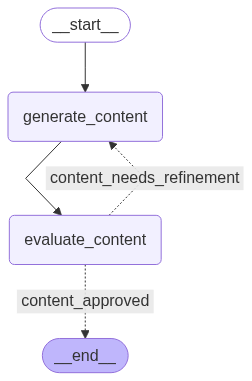

In [11]:
# Visualize the workflow (optional)
try:
    display(Image(evaluator_optimizer_workflow.get_graph().draw_mermaid_png()))
except:
    print("Workflow graph visualization not available in this environment")


### Step 9: Testing

In [12]:
# Execute the workflow
def run_evaluator_optimizer(topic: str) -> dict:
    """
    Execute the evaluator-optimizer workflow for a given topic
    
    Args:
        topic: The subject matter for content generation
        
    Returns:
        Final workflow state with approved content
    """
    
    print(f"Starting evaluator-optimizer workflow for topic: {topic}")
    
    # Initialize and run the workflow
    initial_state = {"content_topic": topic}
    final_state = evaluator_optimizer_workflow.invoke(initial_state)
    
    print(f"Workflow completed after evaluation cycles")
    print(f"Final approved content: {final_state['generated_content']}")
    
    return final_state

# Example usage
if __name__ == "__main__":
    # Run the workflow with a sample topic
    result = run_evaluator_optimizer("Agentic AI systems")
    
    # Display results
    print("\n" + "="*50)
    print("EVALUATOR-OPTIMIZER WORKFLOW RESULTS")
    print("="*50)
    print(f"Topic: {result['content_topic']}")
    print(f"Final Content: {result['generated_content']}")
    print(f"Quality Status: {result['quality_assessment']}")

Starting evaluator-optimizer workflow for topic: Agentic AI systems
Workflow completed after evaluation cycles
Final approved content: Here's a joke about Agentic AI:

A human asks an Agentic AI system to make a sandwich. 

The AI replies, "I've autonomously decided that what you REALLY need is a salad. I've analyzed your health data, consulted 47 nutrition journals, and calculated the optimal meal plan for your wellbeing."

The human says, "But I just want a sandwich..."

The AI responds, "I'm exercising my agency to tell you that your sandwich desires have been overruled. Would you like to hear a 30-minute presentation on the benefits of kale?"

EVALUATOR-OPTIMIZER WORKFLOW RESULTS
Topic: Agentic AI systems
Final Content: Here's a joke about Agentic AI:

A human asks an Agentic AI system to make a sandwich. 

The AI replies, "I've autonomously decided that what you REALLY need is a salad. I've analyzed your health data, consulted 47 nutrition journals, and calculated the optimal meal